In [1]:
import sys
sys.path.append('..')

import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
from matplotlib import pyplot as plt
from pathlib import Path
from monodepth_dataloader import *

plt.rcParams['figure.figsize'] = (10, 12)

def imshow(im, cmap=None):
    plt.figure()
    plt.axis('off')
    plt.imshow(np.squeeze(im), cmap=cmap)

c:\Users\kol\Miniconda3\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\kol\Miniconda3\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\kol\Miniconda3\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\kol\Miniconda3\envs\tf1\lib\site-packages\tensorflow\python\framework\dty

In [2]:
def read_image(image_path):
    image = tf.image.decode_png(tf.read_file(image_path), channels=3)
    image  = tf.image.convert_image_dtype(image,  tf.float32)
    image  = tf.image.resize_images(image,  [256, 256], tf.image.ResizeMethod.AREA)
    return image

In [3]:
def SSIM(x, y):
    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu_x = slim.avg_pool2d(x, 3, 1, 'VALID')
    mu_y = slim.avg_pool2d(y, 3, 1, 'VALID')

    sigma_x  = slim.avg_pool2d(x ** 2, 3, 1, 'VALID') - mu_x ** 2
    sigma_y  = slim.avg_pool2d(y ** 2, 3, 1, 'VALID') - mu_y ** 2
    sigma_xy = slim.avg_pool2d(x * y , 3, 1, 'VALID') - mu_x * mu_y

    SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    SSIM_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)

    SSIM = SSIM_n / SSIM_d

    return tf.clip_by_value((1 - SSIM) / 2, 0, 1)

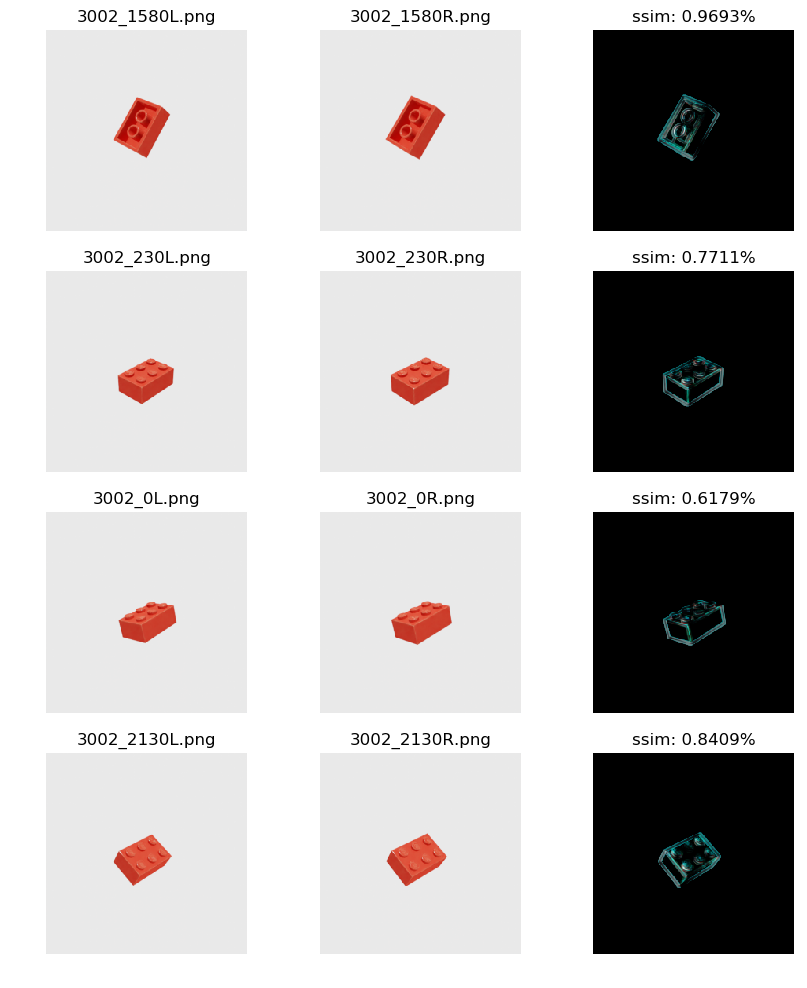

In [4]:

def get_ssim(line):
    split_line = tf.string_split([line]).values
    left_fn = tf.string_join(['..\\bricks\\', split_line[0]])
    right_fn = tf.string_join(['..\\bricks\\', split_line[1]])

    left = read_image(left_fn)
    right = read_image(right_fn)
    ssim = SSIM(tf.expand_dims(left, axis=0), tf.expand_dims(right, axis=0))

    return (left_fn, right_fn), (left, right), ssim, tf.math.reduce_mean(ssim)

with open('filenames/bricks_files.txt', 'r') as fp:
    image_files = fp.read().splitlines()
    sample_files = np.random.choice(image_files, 4)

with tf.Session() as sess:
    _, axs = plt.subplots(4,3)
    for n, v in enumerate(sample_files):
        fnames, images, ssim_matrix, ssim_mean = sess.run(get_ssim(v))
        for m, (fn, im) in enumerate(zip(fnames, images)):
            axs[n][m].imshow(im)
            axs[n][m].set_title(Path(fn.decode('utf-8')).name)
            axs[n][m].axis('off')

        axs[n][2].imshow(np.squeeze(ssim_matrix), cmap='plasma')
        axs[n][2].set_title(f'ssim: {ssim_mean:.4%}')
        axs[n][2].axis('off')